# Netflix Challenge Embedding layer

## This notebook is intended as an example for embedding layers. The goal is to use part of the Netflix Challenge data to create a simple recommendation system and a meaningful embedding for the movies in the dataset.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import os
import tarfile
import gc
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import sys

Using TensorFlow backend.


# Data preperation 

## In this example our terminology will be:
    data - the part of the data we can build our model with.
        split into:
        - train - fitting the model
        - dev - evauate the model during development and tweaking
    probe - the original netflix self-test set for which RMSE were reported

In [2]:
data_df = pd.read_csv('resources/data/train.csv')

In [3]:
print(data_df.shape)
data_df.head()

(99072112, 3)


,user_id,movie_id,rating
0,1488844,1,3
1,822109,1,5
2,885013,1,4
3,823519,1,3
4,893988,1,3


In [4]:
probe_df = pd.read_csv('resources/data/probe.csv')

In [5]:
print(probe_df.shape)
probe_df.head()

(1408395, 3)


,user_id,movie_id,rating
0,30878,1,4
1,2647871,1,4
2,1283744,1,3
3,2488120,1,5
4,317050,1,5


## Exploration 

### Check rating distribution 

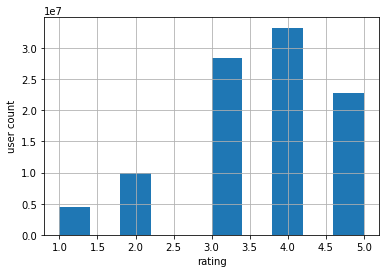

In [6]:
data_df.rating.hist()
plt.xlabel('rating')
plt.ylabel('user count')
plt.show()

### check amount of movies per user (select few to speed up)

In [7]:
sample_df = data_df.loc[:1e6, ['user_id', 'movie_id']]

In [8]:
movies_per_user = sample_df.groupby('user_id').count()
movies_per_user.columns = ['n_movies']

In [9]:
movies_per_user.describe()

,n_movies
count,271730.000000
mean,3.680127
std,3.918240
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,235.000000


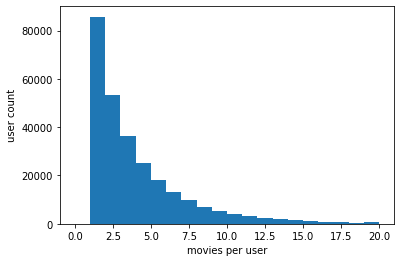

In [10]:
plt.hist(movies_per_user.values, range=(0,20), bins=20)
plt.xlabel('movies per user')
plt.ylabel('user count')
plt.show()

### check amount of users per movie 

In [11]:
users_per_movie = sample_df.groupby('movie_id').count()
users_per_movie.columns = ['n_users']
users_per_movie.describe()

,n_users
count,241.000000
mean,4149.381743
std,13162.642081
min,55.000000
25%,186.000000
50%,456.000000
75%,2269.000000
max,114055.000000


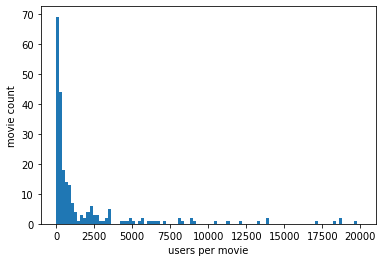

In [12]:
plt.hist(users_per_movie.values, bins=100, range=(0,20000))
plt.xlabel('users per movie')
plt.ylabel('movie count')
plt.show()

### QUESTIONS?

## preprocessing 

In [13]:
X_train, X_dev, y_train, y_dev = train_test_split(data_df.drop('rating', axis = 1), data_df.rating, test_size = 0.3, random_state = 77)

#### we use all the user and movie IDs only to make sure the transformation encodes all movies and users, we don't use the ratings from this set 

#### here we create a new "transformed" column instead of the id, which is ordnial - the movies get numbers from 0 to num_of_movies and same for the users

In [14]:
#this cell creates dictionaries which help with changing the unique ID's into series of int's. 
#This is neccessary for embedding layers in keras (so use the transformed columns later on), 
#especially if you only use part of the data.

list_unique_user = list(set(data_df.user_id).union(set(probe_df.user_id)))
transforming_user = {v:k for k,v in zip(range(len(list_unique_user)), list_unique_user)}
inv_transforming_user = {k:v for k,v in zip(range(len(list_unique_user)), list_unique_user)}

list_unique_movie = list(set(data_df.movie_id).union(set(probe_df.movie_id)))
transforming_movie = {v:k for k,v in zip(range(len(list_unique_movie)), list_unique_movie)}
inv_transforming_movie = {k:v for k,v in zip(range(len(list_unique_movie)), list_unique_movie)}


In [15]:
X_train['user_id_transformed'] = X_train['user_id'].apply(lambda x: transforming_user[x])
X_train['movie_id_transformed'] = X_train['movie_id'].apply(lambda x: transforming_movie[x])

X_dev['user_id_transformed'] = X_dev['user_id'].apply(lambda x: transforming_user[x])
X_dev['movie_id_transformed'] = X_dev['movie_id'].apply(lambda x: transforming_movie[x])

In [16]:
num_of_users = transforming_user[list(transforming_user.keys())[-1]]
num_of_users

480188

In [17]:
num_of_movies = transforming_movie[list(transforming_movie.keys())[-1]]
num_of_movies

17769

In [18]:
X_train.head()

,user_id,movie_id,user_id_transformed,movie_id_transformed
9096243,2480985,1853,139369,1852
53603143,1075324,9954,295385,9953
13434724,906893,2650,264924,2649
63016666,257017,11677,92983,11676
60170577,1721379,11173,412397,11172


In [19]:
y_dev.head()

85733865    3
19059034    4
18459054    4
59155026    4
76136516    2
Name: rating, dtype: int64

# Create Keras model using functional API for predicting user score per movie

In [20]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam 
from keras.layers import LeakyReLU
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from IPython.display import display, Image

In [21]:
batch_size = 2**19

In [22]:
batches_per_epoch = X_train.shape[0]/batch_size
lr_decay = (1./0.75 -1)/batches_per_epoch
lr_decay

0.0025199922438410103

In [23]:
# Model
movie_id_layer = Input(shape=(1,), dtype='int32', name='movie_id')

# ** the +1 in dim is because we need to encode the last valid value as well
movie_embedding_layer = Embedding(input_dim=num_of_movies+1, output_dim=60, 
                                  input_length=1,
                                  name='movie_embedding',
                                 )(movie_id_layer)

user_id_layer = Input(shape=(1,), dtype='int32', name='user_id')

user_embedding_layer = Embedding(input_dim=num_of_users+1, output_dim=20, 
                                 input_length=1,
                                 name='user_embedding',
                                )(user_id_layer)

concat_layer = keras.layers.Concatenate(axis=-1, name='concat_layer')([movie_embedding_layer, user_embedding_layer])

concat_layer_flat = keras.layers.Flatten(name='flatten')(concat_layer)

dense_1 = Dense(1000 ,)(concat_layer_flat)
dense_1_activated = LeakyReLU()(dense_1)

dense_2 = Dense(1000 ,)(dense_1_activated)
dense_2_activated = LeakyReLU()(dense_2)

dense_3 = Dense(10)(dense_2_activated)
dense_3_activated = LeakyReLU()(dense_3)

output_layer = Dense(1, name='output')(dense_3_activated)

model = Model(inputs=[movie_id_layer, user_id_layer], outputs=output_layer)

model.compile(loss= "mean_squared_error" , optimizer=Adam(lr=0.004, decay=lr_decay), metrics=["mean_squared_error"])

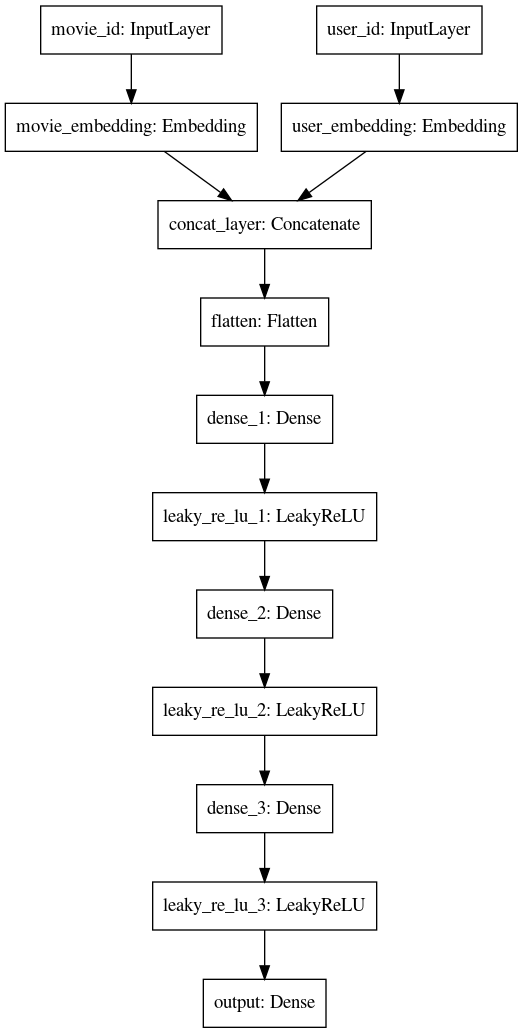

In [24]:
plot_model(model, to_file='model.png', show_shapes=False)
display(Image(filename='model.png'))

### QUESTIONS?

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_id (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 60)        1066200     movie_id[0][0]                   
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        9603780     user_id[0][0]                    
__________________________________________________________________________________________________
concat_lay

## fit 

In [26]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50, restore_best_weights=True)

In [ ]:
model.fit(x=[X_train.movie_id_transformed.values.reshape(-1,1),
             X_train.user_id_transformed.values.reshape(-1,1)],
            y=y_train,
            epochs=100,
            batch_size=batch_size,
            validation_data=([X_dev.movie_id_transformed.values.reshape(-1,1),
                       X_dev.user_id_transformed.values.reshape(-1,1)], 
                             y_dev.values),
            callbacks=[es])

# QUESTIONS?




Train on 69350478 samples, validate on 29721634 samples
Epoch 1/100





69350478/69350478 [==============================] - 57s 1us/step - loss: 1.6289 - mean_squared_error: 1.6289 - val_loss: 0.8572 - val_mean_squared_error: 0.8572
Epoch 2/100
69350478/69350478 [==============================] - 47s 1us/step - loss: 0.8513 - mean_squared_error: 0.8513 - val_loss: 0.8531 - val_mean_squared_error: 0.8531
Epoch 3/100
69350478/69350478 [==============================] - 47s 1us/step - loss: 0.8458 - mean_squared_error: 0.8458 - val_loss: 0.8498 - val_mean_squared_error: 0.8498
Epoch 4/100
69350478/69350478 [==============================] - 47s 1us/step - loss: 0.8378 - mean_squared_error: 0.8378 - val_loss: 0.8361 - val_mean_squared_error: 0.8361
Epoch 5/100
69350478/69350478 [==============================] - 47s 1us/step - loss: 0.8058 - mean_squared_error: 0.8058 - val_loss: 0.7993 - val_mean_squared_error: 0.7993
Epoch 6/100
69350478/69350478 [==============================] - 4

### Eval RMSE on probe data and save model 

In [12]:
from sklearn.metrics import mean_squared_error

In [235]:
RMSE_probe = np.sqrt(mean_squared_error(probe_df.rating, 
                   model.predict([probe_df['movie_id'].apply(lambda x: transforming_movie[x]).values.reshape(-1,1),
                                  probe_df['user_id'].apply(lambda x: transforming_user[x]).values.reshape(-1,1)
                                 ])))
print('RMSE for probe data is: {}'.format(RMSE_probe))

RMSE for probe data is: 0.997990271028259


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/model{0:.4g}.h5'.format(RMSE_probe))

In [ ]:
del X_dev, X_train
gc.collect()

In [ ]:
# from keras import backend as K
# K.clear_session()

# Continue from here if you have a saved model 

### don't forget to run all cells except for model.fit - we will need many of the defined variables 

In [26]:
model = keras.models.load_model('model0.9976.h5')

# Basic recommendation system

In [27]:
# load movie titles per movie id
movie_titles_df = pd.read_csv('resources/movie_titles_fixed.csv', names=['ID', 'name'], usecols=[0,2])
movie_titles_df.set_index('ID', inplace=True)
movie_titles_df.head()

,name
ID,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


In [28]:
def movie_per_user(model, user_id):
    
    # array of all movie counters (0 to number of movies)
    movie_counter_array = np.arange(num_of_movies).reshape(-1,1)
    
    # predict for all movies (and a single inputed user) what is the score
    preds = model.predict([movie_counter_array, np.ones_like(movie_counter_array)*transforming_user[user_id]])

    # find the 10 most highly ranked movies for that user
    highest_ranked_counter = preds.argsort(axis=0)[-10:]
    
    # transform from the ordinal id of the model to the id in the dataset
    vfunc = np.vectorize(lambda x: inv_transforming_movie[x])
    highest_ranked_idx = vfunc(highest_ranked_counter)
    return movie_titles_df.loc[highest_ranked_idx.reshape(-1), :]
    

### find a user like myself 

In [29]:
star_wars_movies = movie_titles_df.iloc[[i for i,name in enumerate(movie_titles_df.name.values) if 'Star Wars' in name],: ]
star_wars_movies

,name
ID,
1237,The Stars of Star Wars
2032,Star Wars Animated Adventures: Ewoks
2610,Star Wars: Ewok Adventures: Caravan of Courage...
5582,Star Wars: Episode V: The Empire Strikes Back
5705,Star Wars: Episode II: Attack of the Clones: B...
7639,Star Wars Trilogy: Bonus Material
8292,Star Wars: Clone Wars: Vol. 1
8420,Star Wars Animated Adventures: Droids
8687,Star Wars: Episode II: Attack of the Clones


In [30]:
star_wars_users_df = data_df.merge(star_wars_movies, left_on='movie_id', right_index=True, how='inner')
star_wars_users_df.head()

,user_id,movie_id,rating,name
6160640,887273,1237,4,The Stars of Star Wars
6160641,948367,1237,3,The Stars of Star Wars
6160642,2189626,1237,3,The Stars of Star Wars
6160643,853261,1237,5,The Stars of Star Wars
6160644,1048199,1237,5,The Stars of Star Wars


In [31]:
num_star_df = star_wars_users_df.groupby('user_id').count().movie_id
num_star_df.head()

user_id
6     6
7     5
8     2
79    5
83    1
Name: movie_id, dtype: int64

In [32]:
num_star_df.iloc[num_star_df.argsort()].tail()

user_id
305344     13
2439493    13
2548453    13
2056022    13
1713267    13
Name: movie_id, dtype: int64

In [33]:
star_wars_users_df.iloc[star_wars_users_df.user_id.values==1713267, :]

,user_id,movie_id,rating,name
6160962,1713267,1237,2,The Stars of Star Wars
10169055,1713267,2032,3,Star Wars Animated Adventures: Ewoks
13258510,1713267,2610,3,Star Wars: Ewok Adventures: Caravan of Courage...
29892474,1713267,5582,5,Star Wars: Episode V: The Empire Strikes Back
30547156,1713267,5705,4,Star Wars: Episode II: Attack of the Clones: B...
42581087,1713267,7639,4,Star Wars Trilogy: Bonus Material
45177143,1713267,8292,5,Star Wars: Clone Wars: Vol. 1
46080440,1713267,8420,3,Star Wars Animated Adventures: Droids
47341377,1713267,8687,5,Star Wars: Episode II: Attack of the Clones
52049561,1713267,9628,5,Star Wars: Episode VI: Return of the Jedi


In [34]:
# movie recommendations for a single user that LOVES star wars
movie_per_user(model, 1713267)

,name
ID,
2782,Braveheart
14550,The Shawshank Redemption: Special Edition
10042,Raiders of the Lost Ark
14240,Lord of the Rings: The Return of the King
5582,Star Wars: Episode V: The Empire Strikes Back
7664,Gladiator: Extended Edition
14961,Lord of the Rings: The Return of the King: Ext...
7230,The Lord of the Rings: The Fellowship of the R...
7057,Lord of the Rings: The Two Towers: Extended Ed...


### QUESTIONS?

# Inspect the Movie embedding using clustering

#### Create a new model, using the trained layers of the existing one.
##### The new model gets a movie_id as an input and returns the embedding in lower dimention

In [35]:
movie_embedding_model = Model(inputs=model.get_layer('movie_id').input, outputs=model.get_layer('movie_embedding').output)

#### plot whole model 

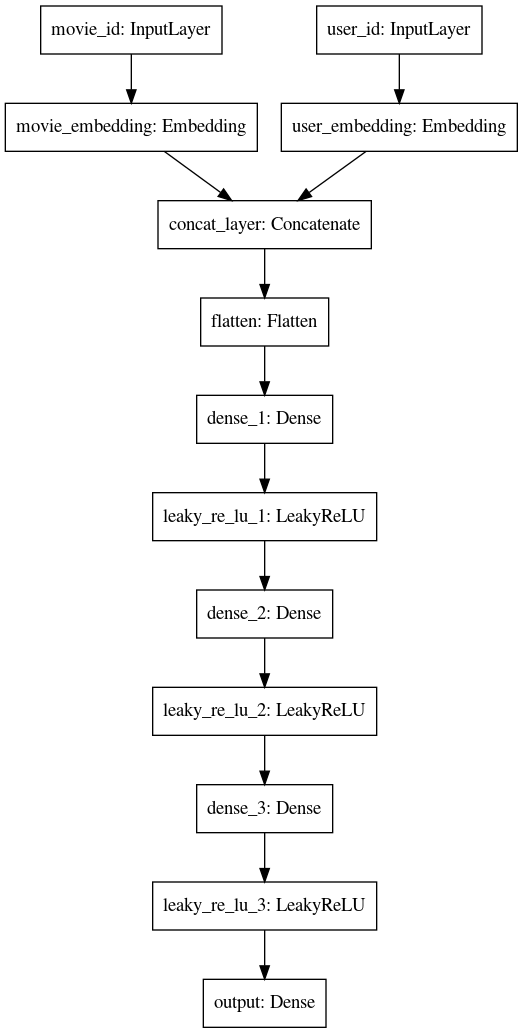

In [36]:
plot_model(model, to_file='model.png', show_shapes=False)
display(Image(filename='model.png'))

#### plot extracted model 

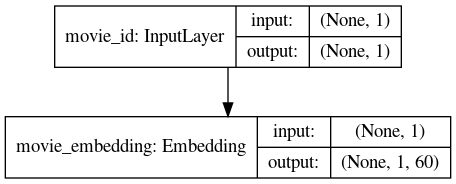

In [37]:
plot_model(movie_embedding_model, to_file='model_embedd.png', show_shapes=True)
display(Image(filename='model_embedd.png'))

In [38]:
# get embedding for all movies
movie_counter_array = np.arange(num_of_movies).reshape(-1,1)
movies_embeddings = movie_embedding_model.predict(movie_counter_array)

In [39]:
movies_embeddings.shape

(17769, 1, 60)

### QUESTIONS?

In [40]:
from sklearn.cluster import KMeans

In [41]:
def get_movies_in_cluster(movie_clustering, n_cluster):
    """ return a list of movie titles that are in a certain cluster
    """
    # cluster num for each movie
    movie_clusters = movie_clustering.labels_.astype(float)
    
    # ordinal id of all movies in the cluster
    movie_count_ids = np.arange(num_of_movies)[movie_clusters==n_cluster]
    
    # retrieve from movie title list using the normal id
    vfunc = np.vectorize(lambda x: inv_transforming_movie[x])
    movie_in_cluster_idx = vfunc(movie_count_ids)
    return movie_titles_df.loc[movie_in_cluster_idx.reshape(-1), :]

### Show a low dimention representation of the embedding 

In [42]:
movie_clustering = KMeans(n_clusters=10, n_jobs=7, random_state=1).fit(
            movies_embeddings.reshape(movies_embeddings.shape[0], movies_embeddings.shape[2]))

#### PCA representation 

In [43]:
from sklearn.decomposition import PCA

In [44]:
movie_pca_2d_transformed_data = PCA(n_components=2).fit_transform(
    movies_embeddings.reshape(movies_embeddings.shape[0], movies_embeddings.shape[2]))

In [45]:
movie_pca_2d_transformed_data.shape

(17769, 2)

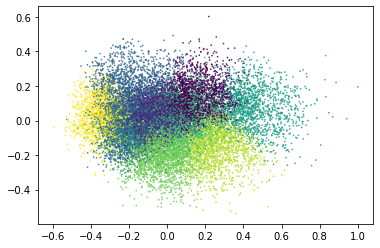

In [46]:
plt.scatter(movie_pca_2d_transformed_data[:,0], movie_pca_2d_transformed_data[:,1],
            c= movie_clustering.labels_.astype(float), s=0.5, alpha=0.8)
plt.show()

In [47]:
movie_titles_df['order_idx'] = [transforming_movie[x] for x in movie_titles_df.index]
movie_titles_df = movie_titles_df.sort_values(by='order_idx')
movie_titles_df.head()

,name,order_idx
ID,,
1,Dinosaur Planet,0
2,Isle of Man TT 2004 Review,1
3,Character,2
4,Paula Abdul's Get Up & Dance,3
5,The Rise and Fall of ECW,4


In [48]:
np.random.seed(7)
idx_show = np.random.choice(movie_titles_df['order_idx'], 40, replace=False, )
idx_star_wars = [transforming_movie[x] for x in star_wars_movies.index]

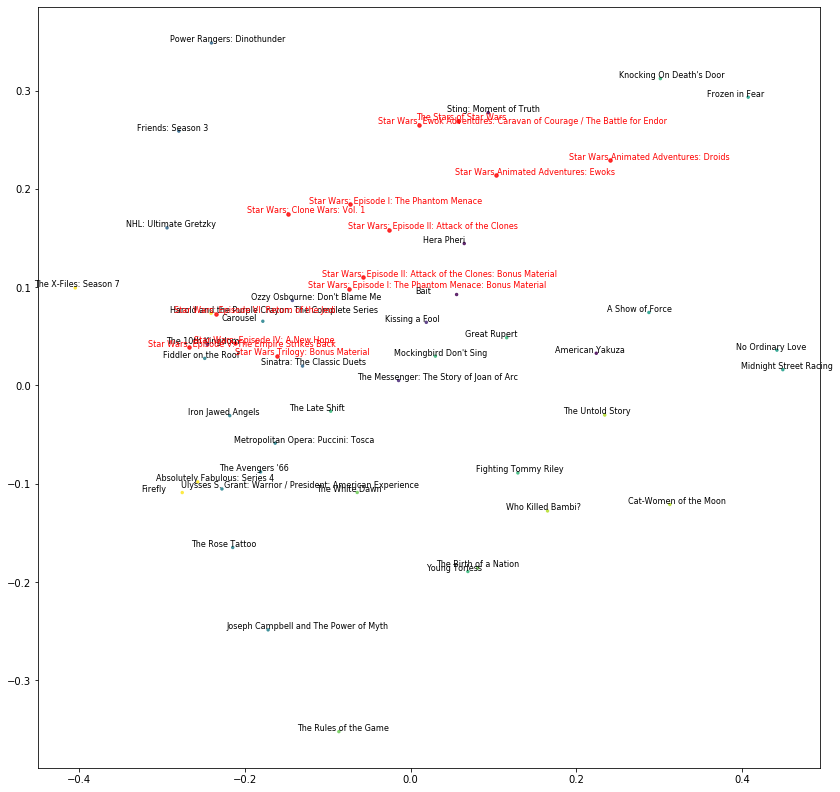

In [49]:
plt.figure(figsize=(14,14))
plt.scatter(movie_pca_2d_transformed_data[idx_show,0], movie_pca_2d_transformed_data[idx_show,1],
            c= movie_clustering.labels_[idx_show].astype(float), s=6, alpha=0.8)
for idx in idx_show:
    plt.text(movie_pca_2d_transformed_data[idx,0]-0.05, movie_pca_2d_transformed_data[idx,1]+0.001, movie_titles_df.iloc[idx,0], fontsize=8)
    
plt.scatter(movie_pca_2d_transformed_data[idx_star_wars,0], movie_pca_2d_transformed_data[idx_star_wars,1],
            c= 'r', s=12, alpha=0.8)
for idx in idx_star_wars:
    plt.text(movie_pca_2d_transformed_data[idx,0]-0.05, movie_pca_2d_transformed_data[idx,1]+0.001, movie_titles_df.iloc[idx,0], fontsize=8,
            fontdict={'color':'r'})
plt.show()

### QUESTIONS?

## Complex recommendation system - different "genres" of movies 

In [50]:
def get_recommendation_per_cluster(model, movie_clustering, user_id):
    """ return a list of movie titles that are in a certain cluster
    """
    # cluster num for each movie
    movie_clusters = movie_clustering.labels_.astype(float)
    
    
    hightest_ranked_movies_idxs = []
    
    # iterate over all clusters
    for n_cluster in np.unique(movie_clusters):
        
        # ordinal id of all movies in cluster
        movie_count_ids = np.arange(num_of_movies)[movie_clusters==n_cluster]

        # predict for all movies in cluster (and a single inputed user) what is the score
        preds = model.predict([movie_count_ids, np.ones_like(movie_count_ids)*transforming_user[user_id]])

        # find the most *predicted to be* highly ranked movie for that user and cluster
        highest_ranked_counter = preds.argsort(axis=0)[-1]

        # transform from the ordinal id of the model to the id in the dataset
        vfunc = np.vectorize(lambda x: inv_transforming_movie[x])
        highest_ranked_idx = vfunc(highest_ranked_counter)
        
        hightest_ranked_movies_idxs.append(highest_ranked_idx)
        
    hightest_ranked_movies_idxs = np.array(hightest_ranked_movies_idxs)
    
    return movie_titles_df.loc[hightest_ranked_movies_idxs.reshape(-1), :]

In [51]:
get_recommendation_per_cluster(model, movie_clustering, 1713267)

,name,order_idx
ID,,
765,Grief,764
1028,The Educational Archives: Vol. 1: Sex & Drugs,1027
402,Pan Tadeusz,401
646,Matewan,645
765,Grief,764
388,Body Chemistry,387
1111,Cries and Whispers,1110
678,Loves of a Blonde,677
984,The Young Lions,983


In [52]:
get_recommendation_per_cluster(model, movie_clustering, 1608708)

,name,order_idx
ID,,
959,Jay Jay the Jet Plane: Lessons for All Seasons,958
1521,The Trouble With Harry,1520
731,Mr. Magoo,730
530,Return to Horror High,529
776,Dr. Seuss's The 5000 Fingers of Dr. T,775
1011,All the Right Moves,1010
1257,Tupperware!: American Experience,1256
1335,Paul McCartney: Back in the U.S.,1334
1097,Winning Strategies: Texas Hold 'Em Poker with ...,1096


In [53]:
get_recommendation_per_cluster(model, movie_clustering, 1283744)

,name,order_idx
ID,,
357,House of Sand and Fog,356
133,Viva La Bam: Season 1,132
290,Harold and Kumar Go to White Castle,289
105,Obsessed,104
1735,Amarcord,1734
600,What's Up Tiger Lily?,599
932,Where Are We?,931
1738,You I Love,1737
1430,The House Next Door,1429


### QUESTIONS?